In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = True

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_0_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_1_connectivity_data_norm_e_k5_b25_t1t2_0_42_n_native_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(657450, 92)
(657450, 8)
validation
(74368, 92)
(74368, 8)
test
(91684, 92)
(91684, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 92)]              0         


 dense (Dense)               (None, 1024)              95232     


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 785288 (3.00 MB)


Trainable params: 785288 (3.00 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/66 [..............................] - ETA: 1:38 - loss: 1.8435 - STD: 0.0660 - MAE: 0.2072

 2/66 [..............................] - ETA: 1:00 - loss: 1.6950 - STD: 0.0906 - MAE: 0.1919

 7/66 [==>...........................] - ETA: 9s - loss: 1.4628 - STD: 0.1843 - MAE: 0.1514  

12/66 [====>.........................] - ETA: 5s - loss: 1.3996 - STD: 0.1832 - MAE: 0.1504

17/66 [======>.......................] - ETA: 3s - loss: 1.3755 - STD: 0.1854 - MAE: 0.1490

22/66 [=========>....................] - ETA: 2s - loss: 1.3624 - STD: 0.1914 - MAE: 0.1463

27/66 [===========>..................] - ETA: 1s - loss: 1.3522 - STD: 0.1909 - MAE: 0.1463

32/66 [=============>................] - ETA: 1s - loss: 1.3458 - STD: 0.1905 - MAE: 0.1463

37/66 [===============>..............] - ETA: 1s - loss: 1.3415 - STD: 0.1917 - MAE: 0.1458

42/66 [==================>...........] - ETA: 0s - loss: 1.3381 - STD: 0.1916 - MAE: 0.1458

47/66 [====================>.........] - ETA: 0s - loss: 1.3350 - STD: 0.1914 - MAE: 0.1458

52/66 [======================>.......] - ETA: 0s - loss: 1.3328 - STD: 0.1916 - MAE: 0.1457

57/66 [========================>.....] - ETA: 0s - loss: 1.3305 - STD: 0.1915 - MAE: 0.1456

62/66 [===========================>..] - ETA: 0s - loss: 1.3291 - STD: 0.1915 - MAE: 0.1456

66/66 [==============================] - 4s 36ms/step - loss: 1.3277 - STD: 0.1915 - MAE: 0.1456 - val_loss: 1.2439 - val_STD: 0.1920 - val_MAE: 0.1418


Epoch 2/10000


 1/66 [..............................] - ETA: 1s - loss: 1.3100 - STD: 0.1920 - MAE: 0.1453

 6/66 [=>............................] - ETA: 0s - loss: 1.3137 - STD: 0.1916 - MAE: 0.1454

11/66 [====>.........................] - ETA: 0s - loss: 1.3139 - STD: 0.1914 - MAE: 0.1456

16/66 [======>.......................] - ETA: 0s - loss: 1.3111 - STD: 0.1915 - MAE: 0.1454

21/66 [========>.....................] - ETA: 0s - loss: 1.3102 - STD: 0.1917 - MAE: 0.1452

26/66 [==========>...................] - ETA: 0s - loss: 1.3081 - STD: 0.1920 - MAE: 0.1450

31/66 [=============>................] - ETA: 0s - loss: 1.3085 - STD: 0.1922 - MAE: 0.1449

36/66 [===============>..............] - ETA: 0s - loss: 1.3086 - STD: 0.1920 - MAE: 0.1450

41/66 [=================>............] - ETA: 0s - loss: 1.3085 - STD: 0.1920 - MAE: 0.1450

46/66 [===================>..........] - ETA: 0s - loss: 1.3081 - STD: 0.1919 - MAE: 0.1450

51/66 [======================>.......] - ETA: 0s - loss: 1.3086 - STD: 0.1919 - MAE: 0.1450

56/66 [========================>.....] - ETA: 0s - loss: 1.3077 - STD: 0.1919 - MAE: 0.1450

61/66 [==========================>...] - ETA: 0s - loss: 1.3073 - STD: 0.1920 - MAE: 0.1450

66/66 [==============================] - ETA: 0s - loss: 1.3071 - STD: 0.1920 - MAE: 0.1450

66/66 [==============================] - 1s 12ms/step - loss: 1.3071 - STD: 0.1920 - MAE: 0.1450 - val_loss: 1.2378 - val_STD: 0.1927 - val_MAE: 0.1411


Epoch 3/10000


 1/66 [..............................] - ETA: 2s - loss: 1.3097 - STD: 0.1929 - MAE: 0.1450

 6/66 [=>............................] - ETA: 0s - loss: 1.3109 - STD: 0.1912 - MAE: 0.1455

11/66 [====>.........................] - ETA: 0s - loss: 1.3057 - STD: 0.1915 - MAE: 0.1450

16/66 [======>.......................] - ETA: 0s - loss: 1.3023 - STD: 0.1911 - MAE: 0.1450

21/66 [========>.....................] - ETA: 0s - loss: 1.2991 - STD: 0.1919 - MAE: 0.1445

26/66 [==========>...................] - ETA: 0s - loss: 1.2947 - STD: 0.1921 - MAE: 0.1442

31/66 [=============>................] - ETA: 0s - loss: 1.2901 - STD: 0.1924 - MAE: 0.1438

36/66 [===============>..............] - ETA: 0s - loss: 1.2872 - STD: 0.1926 - MAE: 0.1436

41/66 [=================>............] - ETA: 0s - loss: 1.2831 - STD: 0.1931 - MAE: 0.1432

46/66 [===================>..........] - ETA: 0s - loss: 1.2791 - STD: 0.1938 - MAE: 0.1427

51/66 [======================>.......] - ETA: 0s - loss: 1.2764 - STD: 0.1944 - MAE: 0.1424

56/66 [========================>.....] - ETA: 0s - loss: 1.2743 - STD: 0.1945 - MAE: 0.1423

61/66 [==========================>...] - ETA: 0s - loss: 1.2714 - STD: 0.1949 - MAE: 0.1421

66/66 [==============================] - ETA: 0s - loss: 1.2691 - STD: 0.1951 - MAE: 0.1419

66/66 [==============================] - 1s 13ms/step - loss: 1.2691 - STD: 0.1951 - MAE: 0.1419 - val_loss: 1.1597 - val_STD: 0.1859 - val_MAE: 0.1399


Epoch 4/10000


 1/66 [..............................] - ETA: 1s - loss: 1.2185 - STD: 0.1954 - MAE: 0.1402

 6/66 [=>............................] - ETA: 0s - loss: 1.2292 - STD: 0.1993 - MAE: 0.1390

11/66 [====>.........................] - ETA: 0s - loss: 1.2318 - STD: 0.1994 - MAE: 0.1390

16/66 [======>.......................] - ETA: 0s - loss: 1.2348 - STD: 0.1988 - MAE: 0.1395

21/66 [========>.....................] - ETA: 0s - loss: 1.2360 - STD: 0.1983 - MAE: 0.1397

26/66 [==========>...................] - ETA: 0s - loss: 1.2358 - STD: 0.1981 - MAE: 0.1398

31/66 [=============>................] - ETA: 0s - loss: 1.2344 - STD: 0.1983 - MAE: 0.1396

36/66 [===============>..............] - ETA: 0s - loss: 1.2333 - STD: 0.1984 - MAE: 0.1395

41/66 [=================>............] - ETA: 0s - loss: 1.2324 - STD: 0.1987 - MAE: 0.1394

46/66 [===================>..........] - ETA: 0s - loss: 1.2306 - STD: 0.1987 - MAE: 0.1393

51/66 [======================>.......] - ETA: 0s - loss: 1.2293 - STD: 0.1989 - MAE: 0.1392

56/66 [========================>.....] - ETA: 0s - loss: 1.2284 - STD: 0.1990 - MAE: 0.1391

61/66 [==========================>...] - ETA: 0s - loss: 1.2274 - STD: 0.1990 - MAE: 0.1391

66/66 [==============================] - ETA: 0s - loss: 1.2257 - STD: 0.1992 - MAE: 0.1389

66/66 [==============================] - 1s 12ms/step - loss: 1.2257 - STD: 0.1992 - MAE: 0.1389 - val_loss: 1.1308 - val_STD: 0.1927 - val_MAE: 0.1363


Epoch 5/10000


 1/66 [..............................] - ETA: 1s - loss: 1.2016 - STD: 0.1989 - MAE: 0.1381

 6/66 [=>............................] - ETA: 0s - loss: 1.2097 - STD: 0.1998 - MAE: 0.1382

11/66 [====>.........................] - ETA: 0s - loss: 1.2115 - STD: 0.2002 - MAE: 0.1381

16/66 [======>.......................] - ETA: 0s - loss: 1.2120 - STD: 0.2000 - MAE: 0.1382

21/66 [========>.....................] - ETA: 0s - loss: 1.2131 - STD: 0.1998 - MAE: 0.1384

26/66 [==========>...................] - ETA: 0s - loss: 1.2121 - STD: 0.2001 - MAE: 0.1383

31/66 [=============>................] - ETA: 0s - loss: 1.2113 - STD: 0.2000 - MAE: 0.1383

36/66 [===============>..............] - ETA: 0s - loss: 1.2101 - STD: 0.2001 - MAE: 0.1382

41/66 [=================>............] - ETA: 0s - loss: 1.2089 - STD: 0.2002 - MAE: 0.1382

46/66 [===================>..........] - ETA: 0s - loss: 1.2072 - STD: 0.2004 - MAE: 0.1380

51/66 [======================>.......] - ETA: 0s - loss: 1.2064 - STD: 0.2004 - MAE: 0.1380

56/66 [========================>.....] - ETA: 0s - loss: 1.2049 - STD: 0.2005 - MAE: 0.1379

61/66 [==========================>...] - ETA: 0s - loss: 1.2045 - STD: 0.2005 - MAE: 0.1379

66/66 [==============================] - ETA: 0s - loss: 1.2031 - STD: 0.2006 - MAE: 0.1378

66/66 [==============================] - 1s 12ms/step - loss: 1.2031 - STD: 0.2006 - MAE: 0.1378 - val_loss: 1.1173 - val_STD: 0.1888 - val_MAE: 0.1374


Epoch 6/10000


 1/66 [..............................] - ETA: 1s - loss: 1.1923 - STD: 0.1948 - MAE: 0.1399

 6/66 [=>............................] - ETA: 0s - loss: 1.1964 - STD: 0.2000 - MAE: 0.1379

11/66 [====>.........................] - ETA: 0s - loss: 1.1946 - STD: 0.2009 - MAE: 0.1374

16/66 [======>.......................] - ETA: 0s - loss: 1.1906 - STD: 0.2013 - MAE: 0.1370

21/66 [========>.....................] - ETA: 0s - loss: 1.1871 - STD: 0.2022 - MAE: 0.1365

26/66 [==========>...................] - ETA: 0s - loss: 1.1860 - STD: 0.2023 - MAE: 0.1364

31/66 [=============>................] - ETA: 0s - loss: 1.1857 - STD: 0.2024 - MAE: 0.1363

36/66 [===============>..............] - ETA: 0s - loss: 1.1849 - STD: 0.2024 - MAE: 0.1363

41/66 [=================>............] - ETA: 0s - loss: 1.1836 - STD: 0.2025 - MAE: 0.1361

46/66 [===================>..........] - ETA: 0s - loss: 1.1823 - STD: 0.2028 - MAE: 0.1360

51/66 [======================>.......] - ETA: 0s - loss: 1.1820 - STD: 0.2030 - MAE: 0.1359

56/66 [========================>.....] - ETA: 0s - loss: 1.1814 - STD: 0.2028 - MAE: 0.1359

61/66 [==========================>...] - ETA: 0s - loss: 1.1809 - STD: 0.2028 - MAE: 0.1359

66/66 [==============================] - ETA: 0s - loss: 1.1804 - STD: 0.2030 - MAE: 0.1358

66/66 [==============================] - 1s 12ms/step - loss: 1.1804 - STD: 0.2030 - MAE: 0.1358 - val_loss: 1.0809 - val_STD: 0.2021 - val_MAE: 0.1300


Epoch 7/10000


 1/66 [..............................] - ETA: 2s - loss: 1.1812 - STD: 0.2082 - MAE: 0.1340

 6/66 [=>............................] - ETA: 0s - loss: 1.1693 - STD: 0.2045 - MAE: 0.1345

11/66 [====>.........................] - ETA: 0s - loss: 1.1678 - STD: 0.2043 - MAE: 0.1345

16/66 [======>.......................] - ETA: 0s - loss: 1.1681 - STD: 0.2048 - MAE: 0.1343

21/66 [========>.....................] - ETA: 0s - loss: 1.1699 - STD: 0.2045 - MAE: 0.1346

26/66 [==========>...................] - ETA: 0s - loss: 1.1678 - STD: 0.2046 - MAE: 0.1345

31/66 [=============>................] - ETA: 0s - loss: 1.1662 - STD: 0.2047 - MAE: 0.1344

36/66 [===============>..............] - ETA: 0s - loss: 1.1646 - STD: 0.2050 - MAE: 0.1342

41/66 [=================>............] - ETA: 0s - loss: 1.1631 - STD: 0.2052 - MAE: 0.1341

46/66 [===================>..........] - ETA: 0s - loss: 1.1622 - STD: 0.2053 - MAE: 0.1339

51/66 [======================>.......] - ETA: 0s - loss: 1.1622 - STD: 0.2053 - MAE: 0.1339

56/66 [========================>.....] - ETA: 0s - loss: 1.1626 - STD: 0.2052 - MAE: 0.1340

61/66 [==========================>...] - ETA: 0s - loss: 1.1622 - STD: 0.2055 - MAE: 0.1339

66/66 [==============================] - ETA: 0s - loss: 1.1622 - STD: 0.2055 - MAE: 0.1339

66/66 [==============================] - 1s 12ms/step - loss: 1.1622 - STD: 0.2055 - MAE: 0.1339 - val_loss: 1.0663 - val_STD: 0.2023 - val_MAE: 0.1290


Epoch 8/10000


 1/66 [..............................] - ETA: 1s - loss: 1.1404 - STD: 0.2090 - MAE: 0.1313

 6/66 [=>............................] - ETA: 0s - loss: 1.1541 - STD: 0.2052 - MAE: 0.1337

11/66 [====>.........................] - ETA: 0s - loss: 1.1558 - STD: 0.2069 - MAE: 0.1330

16/66 [======>.......................] - ETA: 0s - loss: 1.1554 - STD: 0.2062 - MAE: 0.1333

21/66 [========>.....................] - ETA: 0s - loss: 1.1561 - STD: 0.2066 - MAE: 0.1331

26/66 [==========>...................] - ETA: 0s - loss: 1.1560 - STD: 0.2064 - MAE: 0.1332

31/66 [=============>................] - ETA: 0s - loss: 1.1571 - STD: 0.2061 - MAE: 0.1335

36/66 [===============>..............] - ETA: 0s - loss: 1.1568 - STD: 0.2064 - MAE: 0.1333

41/66 [=================>............] - ETA: 0s - loss: 1.1563 - STD: 0.2065 - MAE: 0.1333

46/66 [===================>..........] - ETA: 0s - loss: 1.1550 - STD: 0.2063 - MAE: 0.1333

51/66 [======================>.......] - ETA: 0s - loss: 1.1550 - STD: 0.2066 - MAE: 0.1332

56/66 [========================>.....] - ETA: 0s - loss: 1.1548 - STD: 0.2066 - MAE: 0.1332

60/66 [==========================>...] - ETA: 0s - loss: 1.1547 - STD: 0.2066 - MAE: 0.1332

65/66 [============================>.] - ETA: 0s - loss: 1.1533 - STD: 0.2067 - MAE: 0.1331

66/66 [==============================] - 1s 13ms/step - loss: 1.1531 - STD: 0.2067 - MAE: 0.1330 - val_loss: 1.0535 - val_STD: 0.2082 - val_MAE: 0.1262


Epoch 9/10000


 1/66 [..............................] - ETA: 1s - loss: 1.1413 - STD: 0.2135 - MAE: 0.1295

 6/66 [=>............................] - ETA: 0s - loss: 1.1494 - STD: 0.2068 - MAE: 0.1328

11/66 [====>.........................] - ETA: 0s - loss: 1.1475 - STD: 0.2078 - MAE: 0.1324

16/66 [======>.......................] - ETA: 0s - loss: 1.1496 - STD: 0.2073 - MAE: 0.1326

21/66 [========>.....................] - ETA: 0s - loss: 1.1467 - STD: 0.2075 - MAE: 0.1324

26/66 [==========>...................] - ETA: 0s - loss: 1.1467 - STD: 0.2076 - MAE: 0.1324

31/66 [=============>................] - ETA: 0s - loss: 1.1455 - STD: 0.2077 - MAE: 0.1323

36/66 [===============>..............] - ETA: 0s - loss: 1.1456 - STD: 0.2076 - MAE: 0.1324

41/66 [=================>............] - ETA: 0s - loss: 1.1453 - STD: 0.2075 - MAE: 0.1324

46/66 [===================>..........] - ETA: 0s - loss: 1.1456 - STD: 0.2077 - MAE: 0.1324

51/66 [======================>.......] - ETA: 0s - loss: 1.1462 - STD: 0.2075 - MAE: 0.1324

56/66 [========================>.....] - ETA: 0s - loss: 1.1466 - STD: 0.2076 - MAE: 0.1324

61/66 [==========================>...] - ETA: 0s - loss: 1.1467 - STD: 0.2075 - MAE: 0.1325

66/66 [==============================] - ETA: 0s - loss: 1.1464 - STD: 0.2074 - MAE: 0.1325

66/66 [==============================] - 1s 12ms/step - loss: 1.1464 - STD: 0.2074 - MAE: 0.1325 - val_loss: 1.0570 - val_STD: 0.2074 - val_MAE: 0.1264


Epoch 10/10000


 1/66 [..............................] - ETA: 2s - loss: 1.1465 - STD: 0.2141 - MAE: 0.1297

 6/66 [=>............................] - ETA: 0s - loss: 1.1472 - STD: 0.2069 - MAE: 0.1328

11/66 [====>.........................] - ETA: 0s - loss: 1.1423 - STD: 0.2079 - MAE: 0.1321

16/66 [======>.......................] - ETA: 0s - loss: 1.1446 - STD: 0.2076 - MAE: 0.1324

21/66 [========>.....................] - ETA: 0s - loss: 1.1442 - STD: 0.2076 - MAE: 0.1323

26/66 [==========>...................] - ETA: 0s - loss: 1.1414 - STD: 0.2076 - MAE: 0.1322

31/66 [=============>................] - ETA: 0s - loss: 1.1427 - STD: 0.2077 - MAE: 0.1322

36/66 [===============>..............] - ETA: 0s - loss: 1.1423 - STD: 0.2078 - MAE: 0.1322

41/66 [=================>............] - ETA: 0s - loss: 1.1424 - STD: 0.2076 - MAE: 0.1323

46/66 [===================>..........] - ETA: 0s - loss: 1.1416 - STD: 0.2078 - MAE: 0.1322

51/66 [======================>.......] - ETA: 0s - loss: 1.1412 - STD: 0.2078 - MAE: 0.1321

56/66 [========================>.....] - ETA: 0s - loss: 1.1411 - STD: 0.2078 - MAE: 0.1321

61/66 [==========================>...] - ETA: 0s - loss: 1.1408 - STD: 0.2079 - MAE: 0.1321

66/66 [==============================] - ETA: 0s - loss: 1.1404 - STD: 0.2078 - MAE: 0.1321

66/66 [==============================] - 1s 12ms/step - loss: 1.1404 - STD: 0.2078 - MAE: 0.1321 - val_loss: 1.0380 - val_STD: 0.2086 - val_MAE: 0.1255


Epoch 11/10000


 1/66 [..............................] - ETA: 2s - loss: 1.1226 - STD: 0.2135 - MAE: 0.1290

 6/66 [=>............................] - ETA: 0s - loss: 1.1405 - STD: 0.2099 - MAE: 0.1313

11/66 [====>.........................] - ETA: 0s - loss: 1.1415 - STD: 0.2086 - MAE: 0.1318

16/66 [======>.......................] - ETA: 0s - loss: 1.1408 - STD: 0.2079 - MAE: 0.1321

21/66 [========>.....................] - ETA: 0s - loss: 1.1384 - STD: 0.2085 - MAE: 0.1318

26/66 [==========>...................] - ETA: 0s - loss: 1.1376 - STD: 0.2086 - MAE: 0.1317

31/66 [=============>................] - ETA: 0s - loss: 1.1381 - STD: 0.2083 - MAE: 0.1318

36/66 [===============>..............] - ETA: 0s - loss: 1.1377 - STD: 0.2082 - MAE: 0.1318

41/66 [=================>............] - ETA: 0s - loss: 1.1370 - STD: 0.2083 - MAE: 0.1318

46/66 [===================>..........] - ETA: 0s - loss: 1.1370 - STD: 0.2082 - MAE: 0.1318

51/66 [======================>.......] - ETA: 0s - loss: 1.1361 - STD: 0.2083 - MAE: 0.1317

56/66 [========================>.....] - ETA: 0s - loss: 1.1354 - STD: 0.2086 - MAE: 0.1316

61/66 [==========================>...] - ETA: 0s - loss: 1.1346 - STD: 0.2085 - MAE: 0.1316

66/66 [==============================] - ETA: 0s - loss: 1.1351 - STD: 0.2086 - MAE: 0.1316

66/66 [==============================] - 1s 12ms/step - loss: 1.1351 - STD: 0.2086 - MAE: 0.1316 - val_loss: 1.0463 - val_STD: 0.2007 - val_MAE: 0.1290


Epoch 12/10000


 1/66 [..............................] - ETA: 1s - loss: 1.1214 - STD: 0.2052 - MAE: 0.1324

 6/66 [=>............................] - ETA: 0s - loss: 1.1278 - STD: 0.2073 - MAE: 0.1318

11/66 [====>.........................] - ETA: 0s - loss: 1.1300 - STD: 0.2083 - MAE: 0.1315

16/66 [======>.......................] - ETA: 0s - loss: 1.1317 - STD: 0.2082 - MAE: 0.1316

21/66 [========>.....................] - ETA: 0s - loss: 1.1315 - STD: 0.2082 - MAE: 0.1316

26/66 [==========>...................] - ETA: 0s - loss: 1.1312 - STD: 0.2085 - MAE: 0.1315

31/66 [=============>................] - ETA: 0s - loss: 1.1306 - STD: 0.2086 - MAE: 0.1314

36/66 [===============>..............] - ETA: 0s - loss: 1.1306 - STD: 0.2087 - MAE: 0.1314

41/66 [=================>............] - ETA: 0s - loss: 1.1301 - STD: 0.2086 - MAE: 0.1314

46/66 [===================>..........] - ETA: 0s - loss: 1.1302 - STD: 0.2087 - MAE: 0.1313

51/66 [======================>.......] - ETA: 0s - loss: 1.1300 - STD: 0.2087 - MAE: 0.1313

56/66 [========================>.....] - ETA: 0s - loss: 1.1303 - STD: 0.2088 - MAE: 0.1313

61/66 [==========================>...] - ETA: 0s - loss: 1.1295 - STD: 0.2089 - MAE: 0.1312

66/66 [==============================] - ETA: 0s - loss: 1.1298 - STD: 0.2089 - MAE: 0.1312

66/66 [==============================] - 1s 12ms/step - loss: 1.1298 - STD: 0.2089 - MAE: 0.1312 - val_loss: 1.0389 - val_STD: 0.1980 - val_MAE: 0.1300


Epoch 13/10000


 1/66 [..............................] - ETA: 1s - loss: 1.1103 - STD: 0.2031 - MAE: 0.1328

 6/66 [=>............................] - ETA: 0s - loss: 1.1216 - STD: 0.2090 - MAE: 0.1307

11/66 [====>.........................] - ETA: 0s - loss: 1.1205 - STD: 0.2099 - MAE: 0.1303

16/66 [======>.......................] - ETA: 0s - loss: 1.1226 - STD: 0.2096 - MAE: 0.1306

21/66 [========>.....................] - ETA: 0s - loss: 1.1236 - STD: 0.2096 - MAE: 0.1306

26/66 [==========>...................] - ETA: 0s - loss: 1.1234 - STD: 0.2096 - MAE: 0.1306

31/66 [=============>................] - ETA: 0s - loss: 1.1249 - STD: 0.2093 - MAE: 0.1308

36/66 [===============>..............] - ETA: 0s - loss: 1.1248 - STD: 0.2092 - MAE: 0.1309

41/66 [=================>............] - ETA: 0s - loss: 1.1256 - STD: 0.2092 - MAE: 0.1309

46/66 [===================>..........] - ETA: 0s - loss: 1.1253 - STD: 0.2093 - MAE: 0.1309

51/66 [======================>.......] - ETA: 0s - loss: 1.1246 - STD: 0.2093 - MAE: 0.1309

56/66 [========================>.....] - ETA: 0s - loss: 1.1245 - STD: 0.2092 - MAE: 0.1309

61/66 [==========================>...] - ETA: 0s - loss: 1.1245 - STD: 0.2094 - MAE: 0.1308

66/66 [==============================] - ETA: 0s - loss: 1.1246 - STD: 0.2094 - MAE: 0.1308

66/66 [==============================] - 1s 12ms/step - loss: 1.1246 - STD: 0.2094 - MAE: 0.1308 - val_loss: 1.0422 - val_STD: 0.1949 - val_MAE: 0.1315


Epoch 14/10000


 1/66 [..............................] - ETA: 1s - loss: 1.1295 - STD: 0.1991 - MAE: 0.1355

 6/66 [=>............................] - ETA: 0s - loss: 1.1262 - STD: 0.2085 - MAE: 0.1312

11/66 [====>.........................] - ETA: 0s - loss: 1.1237 - STD: 0.2105 - MAE: 0.1303

16/66 [======>.......................] - ETA: 0s - loss: 1.1266 - STD: 0.2097 - MAE: 0.1307

21/66 [========>.....................] - ETA: 0s - loss: 1.1268 - STD: 0.2094 - MAE: 0.1309

26/66 [==========>...................] - ETA: 0s - loss: 1.1251 - STD: 0.2093 - MAE: 0.1308

31/66 [=============>................] - ETA: 0s - loss: 1.1247 - STD: 0.2096 - MAE: 0.1307

36/66 [===============>..............] - ETA: 0s - loss: 1.1232 - STD: 0.2098 - MAE: 0.1305

41/66 [=================>............] - ETA: 0s - loss: 1.1222 - STD: 0.2098 - MAE: 0.1305

46/66 [===================>..........] - ETA: 0s - loss: 1.1217 - STD: 0.2098 - MAE: 0.1305

51/66 [======================>.......] - ETA: 0s - loss: 1.1217 - STD: 0.2098 - MAE: 0.1305

56/66 [========================>.....] - ETA: 0s - loss: 1.1213 - STD: 0.2097 - MAE: 0.1305

61/66 [==========================>...] - ETA: 0s - loss: 1.1206 - STD: 0.2098 - MAE: 0.1305

66/66 [==============================] - ETA: 0s - loss: 1.1206 - STD: 0.2097 - MAE: 0.1305

66/66 [==============================] - 1s 12ms/step - loss: 1.1206 - STD: 0.2097 - MAE: 0.1305 - val_loss: 1.0235 - val_STD: 0.2133 - val_MAE: 0.1230


Epoch 15/10000


 1/66 [..............................] - ETA: 2s - loss: 1.1072 - STD: 0.2168 - MAE: 0.1269

 6/66 [=>............................] - ETA: 0s - loss: 1.1140 - STD: 0.2125 - MAE: 0.1290

11/66 [====>.........................] - ETA: 0s - loss: 1.1165 - STD: 0.2107 - MAE: 0.1300

16/66 [======>.......................] - ETA: 0s - loss: 1.1174 - STD: 0.2104 - MAE: 0.1301

21/66 [========>.....................] - ETA: 0s - loss: 1.1145 - STD: 0.2105 - MAE: 0.1299

26/66 [==========>...................] - ETA: 0s - loss: 1.1158 - STD: 0.2108 - MAE: 0.1298

31/66 [=============>................] - ETA: 0s - loss: 1.1166 - STD: 0.2107 - MAE: 0.1299

36/66 [===============>..............] - ETA: 0s - loss: 1.1164 - STD: 0.2106 - MAE: 0.1300

41/66 [=================>............] - ETA: 0s - loss: 1.1166 - STD: 0.2104 - MAE: 0.1301

46/66 [===================>..........] - ETA: 0s - loss: 1.1168 - STD: 0.2104 - MAE: 0.1301

51/66 [======================>.......] - ETA: 0s - loss: 1.1170 - STD: 0.2104 - MAE: 0.1301

56/66 [========================>.....] - ETA: 0s - loss: 1.1169 - STD: 0.2104 - MAE: 0.1301

61/66 [==========================>...] - ETA: 0s - loss: 1.1171 - STD: 0.2104 - MAE: 0.1301

66/66 [==============================] - ETA: 0s - loss: 1.1168 - STD: 0.2104 - MAE: 0.1301

66/66 [==============================] - 1s 12ms/step - loss: 1.1168 - STD: 0.2104 - MAE: 0.1301 - val_loss: 1.0334 - val_STD: 0.2033 - val_MAE: 0.1275


Epoch 16/10000


 1/66 [..............................] - ETA: 1s - loss: 1.1108 - STD: 0.2080 - MAE: 0.1307

 6/66 [=>............................] - ETA: 0s - loss: 1.1148 - STD: 0.2110 - MAE: 0.1298

11/66 [====>.........................] - ETA: 0s - loss: 1.1167 - STD: 0.2111 - MAE: 0.1298

16/66 [======>.......................] - ETA: 0s - loss: 1.1158 - STD: 0.2106 - MAE: 0.1300

21/66 [========>.....................] - ETA: 0s - loss: 1.1134 - STD: 0.2110 - MAE: 0.1297

26/66 [==========>...................] - ETA: 0s - loss: 1.1119 - STD: 0.2109 - MAE: 0.1296

31/66 [=============>................] - ETA: 0s - loss: 1.1128 - STD: 0.2107 - MAE: 0.1297

36/66 [===============>..............] - ETA: 0s - loss: 1.1121 - STD: 0.2110 - MAE: 0.1296

41/66 [=================>............] - ETA: 0s - loss: 1.1115 - STD: 0.2113 - MAE: 0.1295

46/66 [===================>..........] - ETA: 0s - loss: 1.1109 - STD: 0.2111 - MAE: 0.1295

51/66 [======================>.......] - ETA: 0s - loss: 1.1117 - STD: 0.2109 - MAE: 0.1296

56/66 [========================>.....] - ETA: 0s - loss: 1.1125 - STD: 0.2108 - MAE: 0.1297

61/66 [==========================>...] - ETA: 0s - loss: 1.1125 - STD: 0.2108 - MAE: 0.1297

66/66 [==============================] - ETA: 0s - loss: 1.1129 - STD: 0.2108 - MAE: 0.1297

66/66 [==============================] - 1s 12ms/step - loss: 1.1129 - STD: 0.2108 - MAE: 0.1297 - val_loss: 1.0345 - val_STD: 0.2068 - val_MAE: 0.1258


Epoch 17/10000


 1/66 [..............................] - ETA: 2s - loss: 1.1050 - STD: 0.2115 - MAE: 0.1290

 6/66 [=>............................] - ETA: 0s - loss: 1.1120 - STD: 0.2108 - MAE: 0.1297

11/66 [====>.........................] - ETA: 0s - loss: 1.1088 - STD: 0.2108 - MAE: 0.1296

16/66 [======>.......................] - ETA: 0s - loss: 1.1083 - STD: 0.2111 - MAE: 0.1294

21/66 [========>.....................] - ETA: 0s - loss: 1.1073 - STD: 0.2111 - MAE: 0.1293

26/66 [==========>...................] - ETA: 0s - loss: 1.1082 - STD: 0.2110 - MAE: 0.1294

31/66 [=============>................] - ETA: 0s - loss: 1.1084 - STD: 0.2110 - MAE: 0.1295

36/66 [===============>..............] - ETA: 0s - loss: 1.1084 - STD: 0.2109 - MAE: 0.1295

41/66 [=================>............] - ETA: 0s - loss: 1.1071 - STD: 0.2110 - MAE: 0.1294

46/66 [===================>..........] - ETA: 0s - loss: 1.1082 - STD: 0.2111 - MAE: 0.1294

51/66 [======================>.......] - ETA: 0s - loss: 1.1085 - STD: 0.2111 - MAE: 0.1294

56/66 [========================>.....] - ETA: 0s - loss: 1.1079 - STD: 0.2111 - MAE: 0.1294

61/66 [==========================>...] - ETA: 0s - loss: 1.1084 - STD: 0.2110 - MAE: 0.1294

66/66 [==============================] - ETA: 0s - loss: 1.1081 - STD: 0.2110 - MAE: 0.1294

66/66 [==============================] - 1s 12ms/step - loss: 1.1081 - STD: 0.2110 - MAE: 0.1294 - val_loss: 1.0135 - val_STD: 0.2111 - val_MAE: 0.1235


Epoch 18/10000


 1/66 [..............................] - ETA: 1s - loss: 1.0953 - STD: 0.2141 - MAE: 0.1274

 6/66 [=>............................] - ETA: 0s - loss: 1.1051 - STD: 0.2120 - MAE: 0.1290

11/66 [====>.........................] - ETA: 0s - loss: 1.1060 - STD: 0.2116 - MAE: 0.1291

16/66 [======>.......................] - ETA: 0s - loss: 1.1051 - STD: 0.2121 - MAE: 0.1288

21/66 [========>.....................] - ETA: 0s - loss: 1.1037 - STD: 0.2120 - MAE: 0.1288

26/66 [==========>...................] - ETA: 0s - loss: 1.1048 - STD: 0.2120 - MAE: 0.1289

31/66 [=============>................] - ETA: 0s - loss: 1.1053 - STD: 0.2118 - MAE: 0.1290

36/66 [===============>..............] - ETA: 0s - loss: 1.1061 - STD: 0.2115 - MAE: 0.1291

41/66 [=================>............] - ETA: 0s - loss: 1.1066 - STD: 0.2116 - MAE: 0.1292

46/66 [===================>..........] - ETA: 0s - loss: 1.1065 - STD: 0.2115 - MAE: 0.1292

51/66 [======================>.......] - ETA: 0s - loss: 1.1067 - STD: 0.2115 - MAE: 0.1292

56/66 [========================>.....] - ETA: 0s - loss: 1.1072 - STD: 0.2114 - MAE: 0.1293

61/66 [==========================>...] - ETA: 0s - loss: 1.1073 - STD: 0.2113 - MAE: 0.1293

66/66 [==============================] - ETA: 0s - loss: 1.1065 - STD: 0.2114 - MAE: 0.1292

66/66 [==============================] - 1s 12ms/step - loss: 1.1065 - STD: 0.2114 - MAE: 0.1292 - val_loss: 1.0214 - val_STD: 0.2142 - val_MAE: 0.1224


Epoch 19/10000


 1/66 [..............................] - ETA: 1s - loss: 1.1135 - STD: 0.2182 - MAE: 0.1270

 6/66 [=>............................] - ETA: 0s - loss: 1.1124 - STD: 0.2111 - MAE: 0.1297

11/66 [====>.........................] - ETA: 0s - loss: 1.1111 - STD: 0.2106 - MAE: 0.1299

16/66 [======>.......................] - ETA: 0s - loss: 1.1091 - STD: 0.2112 - MAE: 0.1295

21/66 [========>.....................] - ETA: 0s - loss: 1.1070 - STD: 0.2118 - MAE: 0.1291

26/66 [==========>...................] - ETA: 0s - loss: 1.1059 - STD: 0.2114 - MAE: 0.1292

31/66 [=============>................] - ETA: 0s - loss: 1.1058 - STD: 0.2115 - MAE: 0.1292

36/66 [===============>..............] - ETA: 0s - loss: 1.1061 - STD: 0.2116 - MAE: 0.1291

41/66 [=================>............] - ETA: 0s - loss: 1.1056 - STD: 0.2117 - MAE: 0.1291

46/66 [===================>..........] - ETA: 0s - loss: 1.1058 - STD: 0.2117 - MAE: 0.1291

51/66 [======================>.......] - ETA: 0s - loss: 1.1061 - STD: 0.2116 - MAE: 0.1291

56/66 [========================>.....] - ETA: 0s - loss: 1.1051 - STD: 0.2116 - MAE: 0.1291

61/66 [==========================>...] - ETA: 0s - loss: 1.1048 - STD: 0.2116 - MAE: 0.1291

66/66 [==============================] - ETA: 0s - loss: 1.1046 - STD: 0.2117 - MAE: 0.1290

66/66 [==============================] - 1s 12ms/step - loss: 1.1046 - STD: 0.2117 - MAE: 0.1290 - val_loss: 1.0176 - val_STD: 0.2106 - val_MAE: 0.1238


Epoch 20/10000


 1/66 [..............................] - ETA: 1s - loss: 1.1017 - STD: 0.2132 - MAE: 0.1281

 6/66 [=>............................] - ETA: 0s - loss: 1.0984 - STD: 0.2126 - MAE: 0.1282

11/66 [====>.........................] - ETA: 0s - loss: 1.1016 - STD: 0.2119 - MAE: 0.1288

16/66 [======>.......................] - ETA: 0s - loss: 1.1040 - STD: 0.2115 - MAE: 0.1291

21/66 [========>.....................] - ETA: 0s - loss: 1.1031 - STD: 0.2114 - MAE: 0.1291

26/66 [==========>...................] - ETA: 0s - loss: 1.1033 - STD: 0.2118 - MAE: 0.1290

31/66 [=============>................] - ETA: 0s - loss: 1.1031 - STD: 0.2117 - MAE: 0.1290

36/66 [===============>..............] - ETA: 0s - loss: 1.1019 - STD: 0.2117 - MAE: 0.1289

41/66 [=================>............] - ETA: 0s - loss: 1.1011 - STD: 0.2119 - MAE: 0.1288

46/66 [===================>..........] - ETA: 0s - loss: 1.1015 - STD: 0.2118 - MAE: 0.1289

51/66 [======================>.......] - ETA: 0s - loss: 1.1011 - STD: 0.2117 - MAE: 0.1289

56/66 [========================>.....] - ETA: 0s - loss: 1.1012 - STD: 0.2118 - MAE: 0.1289

61/66 [==========================>...] - ETA: 0s - loss: 1.1010 - STD: 0.2119 - MAE: 0.1288

66/66 [==============================] - ETA: 0s - loss: 1.1009 - STD: 0.2119 - MAE: 0.1288

66/66 [==============================] - 1s 12ms/step - loss: 1.1009 - STD: 0.2119 - MAE: 0.1288 - val_loss: 1.0138 - val_STD: 0.2083 - val_MAE: 0.1247


Epoch 21/10000


 1/66 [..............................] - ETA: 1s - loss: 1.0895 - STD: 0.2111 - MAE: 0.1287

 6/66 [=>............................] - ETA: 0s - loss: 1.0958 - STD: 0.2126 - MAE: 0.1284

11/66 [====>.........................] - ETA: 0s - loss: 1.0979 - STD: 0.2120 - MAE: 0.1287

16/66 [======>.......................] - ETA: 0s - loss: 1.0987 - STD: 0.2113 - MAE: 0.1290

21/66 [========>.....................] - ETA: 0s - loss: 1.0967 - STD: 0.2123 - MAE: 0.1285

26/66 [==========>...................] - ETA: 0s - loss: 1.0985 - STD: 0.2123 - MAE: 0.1286

31/66 [=============>................] - ETA: 0s - loss: 1.0992 - STD: 0.2119 - MAE: 0.1288

36/66 [===============>..............] - ETA: 0s - loss: 1.0996 - STD: 0.2119 - MAE: 0.1287

41/66 [=================>............] - ETA: 0s - loss: 1.0998 - STD: 0.2119 - MAE: 0.1287

46/66 [===================>..........] - ETA: 0s - loss: 1.0995 - STD: 0.2120 - MAE: 0.1287

51/66 [======================>.......] - ETA: 0s - loss: 1.0997 - STD: 0.2121 - MAE: 0.1287

56/66 [========================>.....] - ETA: 0s - loss: 1.0989 - STD: 0.2120 - MAE: 0.1287

61/66 [==========================>...] - ETA: 0s - loss: 1.0988 - STD: 0.2120 - MAE: 0.1286

66/66 [==============================] - ETA: 0s - loss: 1.0988 - STD: 0.2121 - MAE: 0.1287

66/66 [==============================] - 1s 12ms/step - loss: 1.0988 - STD: 0.2121 - MAE: 0.1287 - val_loss: 1.0227 - val_STD: 0.2051 - val_MAE: 0.1261


Epoch 22/10000


 1/66 [..............................] - ETA: 1s - loss: 1.0859 - STD: 0.2087 - MAE: 0.1294

 6/66 [=>............................] - ETA: 0s - loss: 1.0941 - STD: 0.2133 - MAE: 0.1279

11/66 [====>.........................] - ETA: 0s - loss: 1.0984 - STD: 0.2122 - MAE: 0.1287

16/66 [======>.......................] - ETA: 0s - loss: 1.1007 - STD: 0.2119 - MAE: 0.1290

21/66 [========>.....................] - ETA: 0s - loss: 1.1006 - STD: 0.2114 - MAE: 0.1291

26/66 [==========>...................] - ETA: 0s - loss: 1.0994 - STD: 0.2118 - MAE: 0.1289

31/66 [=============>................] - ETA: 0s - loss: 1.0990 - STD: 0.2121 - MAE: 0.1287

36/66 [===============>..............] - ETA: 0s - loss: 1.0985 - STD: 0.2121 - MAE: 0.1287

41/66 [=================>............] - ETA: 0s - loss: 1.0977 - STD: 0.2120 - MAE: 0.1287

46/66 [===================>..........] - ETA: 0s - loss: 1.0982 - STD: 0.2119 - MAE: 0.1287

51/66 [======================>.......] - ETA: 0s - loss: 1.0980 - STD: 0.2120 - MAE: 0.1287

56/66 [========================>.....] - ETA: 0s - loss: 1.0977 - STD: 0.2121 - MAE: 0.1286

61/66 [==========================>...] - ETA: 0s - loss: 1.0972 - STD: 0.2122 - MAE: 0.1286

66/66 [==============================] - ETA: 0s - loss: 1.0966 - STD: 0.2123 - MAE: 0.1285

66/66 [==============================] - 1s 12ms/step - loss: 1.0966 - STD: 0.2123 - MAE: 0.1285 - val_loss: 1.0160 - val_STD: 0.2079 - val_MAE: 0.1249


Epoch 23/10000


 1/66 [..............................] - ETA: 1s - loss: 1.0809 - STD: 0.2111 - MAE: 0.1280

 6/66 [=>............................] - ETA: 0s - loss: 1.0912 - STD: 0.2123 - MAE: 0.1283

11/66 [====>.........................] - ETA: 0s - loss: 1.0942 - STD: 0.2116 - MAE: 0.1287

16/66 [======>.......................] - ETA: 0s - loss: 1.0941 - STD: 0.2120 - MAE: 0.1285

21/66 [========>.....................] - ETA: 0s - loss: 1.0954 - STD: 0.2122 - MAE: 0.1285

26/66 [==========>...................] - ETA: 0s - loss: 1.0949 - STD: 0.2121 - MAE: 0.1285

31/66 [=============>................] - ETA: 0s - loss: 1.0954 - STD: 0.2121 - MAE: 0.1285

36/66 [===============>..............] - ETA: 0s - loss: 1.0946 - STD: 0.2124 - MAE: 0.1284

41/66 [=================>............] - ETA: 0s - loss: 1.0952 - STD: 0.2123 - MAE: 0.1285

46/66 [===================>..........] - ETA: 0s - loss: 1.0949 - STD: 0.2123 - MAE: 0.1284

51/66 [======================>.......] - ETA: 0s - loss: 1.0947 - STD: 0.2123 - MAE: 0.1284

56/66 [========================>.....] - ETA: 0s - loss: 1.0950 - STD: 0.2123 - MAE: 0.1285

61/66 [==========================>...] - ETA: 0s - loss: 1.0943 - STD: 0.2123 - MAE: 0.1284

66/66 [==============================] - ETA: 0s - loss: 1.0941 - STD: 0.2124 - MAE: 0.1284

66/66 [==============================] - 1s 12ms/step - loss: 1.0941 - STD: 0.2124 - MAE: 0.1284 - val_loss: 1.0294 - val_STD: 0.2060 - val_MAE: 0.1258


Epoch 24/10000


 1/66 [..............................] - ETA: 2s - loss: 1.0899 - STD: 0.2103 - MAE: 0.1290

 6/66 [=>............................] - ETA: 0s - loss: 1.0911 - STD: 0.2134 - MAE: 0.1278

11/66 [====>.........................] - ETA: 0s - loss: 1.0918 - STD: 0.2132 - MAE: 0.1280

16/66 [======>.......................] - ETA: 0s - loss: 1.0925 - STD: 0.2124 - MAE: 0.1283

21/66 [========>.....................] - ETA: 0s - loss: 1.0924 - STD: 0.2127 - MAE: 0.1282

26/66 [==========>...................] - ETA: 0s - loss: 1.0922 - STD: 0.2126 - MAE: 0.1282

31/66 [=============>................] - ETA: 0s - loss: 1.0913 - STD: 0.2129 - MAE: 0.1281

36/66 [===============>..............] - ETA: 0s - loss: 1.0908 - STD: 0.2128 - MAE: 0.1281

41/66 [=================>............] - ETA: 0s - loss: 1.0923 - STD: 0.2128 - MAE: 0.1281

46/66 [===================>..........] - ETA: 0s - loss: 1.0922 - STD: 0.2127 - MAE: 0.1281

51/66 [======================>.......] - ETA: 0s - loss: 1.0923 - STD: 0.2126 - MAE: 0.1282

56/66 [========================>.....] - ETA: 0s - loss: 1.0919 - STD: 0.2128 - MAE: 0.1281

61/66 [==========================>...] - ETA: 0s - loss: 1.0921 - STD: 0.2127 - MAE: 0.1282

66/66 [==============================] - ETA: 0s - loss: 1.0925 - STD: 0.2125 - MAE: 0.1282

66/66 [==============================] - 1s 12ms/step - loss: 1.0925 - STD: 0.2125 - MAE: 0.1282 - val_loss: 1.0026 - val_STD: 0.2103 - val_MAE: 0.1237


Epoch 25/10000


 1/66 [..............................] - ETA: 1s - loss: 1.1189 - STD: 0.2109 - MAE: 0.1307

 6/66 [=>............................] - ETA: 0s - loss: 1.0933 - STD: 0.2139 - MAE: 0.1277

11/66 [====>.........................] - ETA: 0s - loss: 1.0927 - STD: 0.2130 - MAE: 0.1280

16/66 [======>.......................] - ETA: 0s - loss: 1.0930 - STD: 0.2131 - MAE: 0.1280

21/66 [========>.....................] - ETA: 0s - loss: 1.0905 - STD: 0.2130 - MAE: 0.1280

26/66 [==========>...................] - ETA: 0s - loss: 1.0908 - STD: 0.2131 - MAE: 0.1280

31/66 [=============>................] - ETA: 0s - loss: 1.0927 - STD: 0.2127 - MAE: 0.1282

36/66 [===============>..............] - ETA: 0s - loss: 1.0928 - STD: 0.2125 - MAE: 0.1283

41/66 [=================>............] - ETA: 0s - loss: 1.0924 - STD: 0.2127 - MAE: 0.1282

46/66 [===================>..........] - ETA: 0s - loss: 1.0928 - STD: 0.2127 - MAE: 0.1282

51/66 [======================>.......] - ETA: 0s - loss: 1.0926 - STD: 0.2127 - MAE: 0.1282

56/66 [========================>.....] - ETA: 0s - loss: 1.0921 - STD: 0.2127 - MAE: 0.1282

61/66 [==========================>...] - ETA: 0s - loss: 1.0919 - STD: 0.2126 - MAE: 0.1282

66/66 [==============================] - ETA: 0s - loss: 1.0914 - STD: 0.2127 - MAE: 0.1281

66/66 [==============================] - 1s 12ms/step - loss: 1.0914 - STD: 0.2127 - MAE: 0.1281 - val_loss: 1.0042 - val_STD: 0.2209 - val_MAE: 0.1193


Epoch 26/10000


 1/66 [..............................] - ETA: 1s - loss: 1.1027 - STD: 0.2230 - MAE: 0.1241

 6/66 [=>............................] - ETA: 0s - loss: 1.0895 - STD: 0.2134 - MAE: 0.1277

11/66 [====>.........................] - ETA: 0s - loss: 1.0882 - STD: 0.2130 - MAE: 0.1279

16/66 [======>.......................] - ETA: 0s - loss: 1.0888 - STD: 0.2131 - MAE: 0.1279

21/66 [========>.....................] - ETA: 0s - loss: 1.0896 - STD: 0.2133 - MAE: 0.1278

26/66 [==========>...................] - ETA: 0s - loss: 1.0900 - STD: 0.2128 - MAE: 0.1280

31/66 [=============>................] - ETA: 0s - loss: 1.0894 - STD: 0.2128 - MAE: 0.1280

36/66 [===============>..............] - ETA: 0s - loss: 1.0890 - STD: 0.2129 - MAE: 0.1280

41/66 [=================>............] - ETA: 0s - loss: 1.0897 - STD: 0.2128 - MAE: 0.1280

46/66 [===================>..........] - ETA: 0s - loss: 1.0902 - STD: 0.2129 - MAE: 0.1280

51/66 [======================>.......] - ETA: 0s - loss: 1.0913 - STD: 0.2129 - MAE: 0.1281

56/66 [========================>.....] - ETA: 0s - loss: 1.0914 - STD: 0.2128 - MAE: 0.1281

61/66 [==========================>...] - ETA: 0s - loss: 1.0908 - STD: 0.2128 - MAE: 0.1281

66/66 [==============================] - ETA: 0s - loss: 1.0904 - STD: 0.2129 - MAE: 0.1280

66/66 [==============================] - 1s 12ms/step - loss: 1.0904 - STD: 0.2129 - MAE: 0.1280 - val_loss: 1.0189 - val_STD: 0.2113 - val_MAE: 0.1234


Epoch 27/10000


 1/66 [..............................] - ETA: 2s - loss: 1.0970 - STD: 0.2146 - MAE: 0.1275

 6/66 [=>............................] - ETA: 0s - loss: 1.0872 - STD: 0.2132 - MAE: 0.1277

11/66 [====>.........................] - ETA: 0s - loss: 1.0872 - STD: 0.2131 - MAE: 0.1278

16/66 [======>.......................] - ETA: 0s - loss: 1.0906 - STD: 0.2122 - MAE: 0.1284

21/66 [========>.....................] - ETA: 0s - loss: 1.0882 - STD: 0.2124 - MAE: 0.1282

26/66 [==========>...................] - ETA: 0s - loss: 1.0878 - STD: 0.2127 - MAE: 0.1280

31/66 [=============>................] - ETA: 0s - loss: 1.0883 - STD: 0.2128 - MAE: 0.1280

36/66 [===============>..............] - ETA: 0s - loss: 1.0871 - STD: 0.2129 - MAE: 0.1279

41/66 [=================>............] - ETA: 0s - loss: 1.0863 - STD: 0.2130 - MAE: 0.1278

46/66 [===================>..........] - ETA: 0s - loss: 1.0866 - STD: 0.2129 - MAE: 0.1279

51/66 [======================>.......] - ETA: 0s - loss: 1.0869 - STD: 0.2128 - MAE: 0.1279

56/66 [========================>.....] - ETA: 0s - loss: 1.0867 - STD: 0.2130 - MAE: 0.1279

61/66 [==========================>...] - ETA: 0s - loss: 1.0864 - STD: 0.2130 - MAE: 0.1278

66/66 [==============================] - ETA: 0s - loss: 1.0865 - STD: 0.2129 - MAE: 0.1279

66/66 [==============================] - 1s 12ms/step - loss: 1.0865 - STD: 0.2129 - MAE: 0.1279 - val_loss: 1.0217 - val_STD: 0.2097 - val_MAE: 0.1240


Epoch 28/10000


 1/66 [..............................] - ETA: 1s - loss: 1.0810 - STD: 0.2127 - MAE: 0.1275

 6/66 [=>............................] - ETA: 0s - loss: 1.0888 - STD: 0.2150 - MAE: 0.1272

11/66 [====>.........................] - ETA: 0s - loss: 1.0867 - STD: 0.2140 - MAE: 0.1274

16/66 [======>.......................] - ETA: 0s - loss: 1.0871 - STD: 0.2132 - MAE: 0.1278

21/66 [========>.....................] - ETA: 0s - loss: 1.0869 - STD: 0.2130 - MAE: 0.1278

26/66 [==========>...................] - ETA: 0s - loss: 1.0868 - STD: 0.2128 - MAE: 0.1279

31/66 [=============>................] - ETA: 0s - loss: 1.0867 - STD: 0.2131 - MAE: 0.1278

36/66 [===============>..............] - ETA: 0s - loss: 1.0864 - STD: 0.2133 - MAE: 0.1277

41/66 [=================>............] - ETA: 0s - loss: 1.0861 - STD: 0.2133 - MAE: 0.1277

46/66 [===================>..........] - ETA: 0s - loss: 1.0863 - STD: 0.2131 - MAE: 0.1278

51/66 [======================>.......] - ETA: 0s - loss: 1.0853 - STD: 0.2131 - MAE: 0.1278

56/66 [========================>.....] - ETA: 0s - loss: 1.0852 - STD: 0.2132 - MAE: 0.1277

61/66 [==========================>...] - ETA: 0s - loss: 1.0853 - STD: 0.2131 - MAE: 0.1277

66/66 [==============================] - ETA: 0s - loss: 1.0851 - STD: 0.2132 - MAE: 0.1277

66/66 [==============================] - 1s 12ms/step - loss: 1.0851 - STD: 0.2132 - MAE: 0.1277 - val_loss: 1.0088 - val_STD: 0.2043 - val_MAE: 0.1264


Epoch 29/10000


 1/66 [..............................] - ETA: 1s - loss: 1.0966 - STD: 0.2056 - MAE: 0.1317

 6/66 [=>............................] - ETA: 0s - loss: 1.0840 - STD: 0.2118 - MAE: 0.1283

11/66 [====>.........................] - ETA: 0s - loss: 1.0854 - STD: 0.2122 - MAE: 0.1282

16/66 [======>.......................] - ETA: 0s - loss: 1.0862 - STD: 0.2128 - MAE: 0.1279

21/66 [========>.....................] - ETA: 0s - loss: 1.0851 - STD: 0.2133 - MAE: 0.1276

26/66 [==========>...................] - ETA: 0s - loss: 1.0860 - STD: 0.2130 - MAE: 0.1278

31/66 [=============>................] - ETA: 0s - loss: 1.0860 - STD: 0.2128 - MAE: 0.1279

36/66 [===============>..............] - ETA: 0s - loss: 1.0867 - STD: 0.2128 - MAE: 0.1280

41/66 [=================>............] - ETA: 0s - loss: 1.0868 - STD: 0.2129 - MAE: 0.1280

46/66 [===================>..........] - ETA: 0s - loss: 1.0864 - STD: 0.2132 - MAE: 0.1278

51/66 [======================>.......] - ETA: 0s - loss: 1.0864 - STD: 0.2131 - MAE: 0.1278

56/66 [========================>.....] - ETA: 0s - loss: 1.0866 - STD: 0.2129 - MAE: 0.1279

61/66 [==========================>...] - ETA: 0s - loss: 1.0855 - STD: 0.2131 - MAE: 0.1278

66/66 [==============================] - ETA: 0s - loss: 1.0850 - STD: 0.2131 - MAE: 0.1277

66/66 [==============================] - 1s 12ms/step - loss: 1.0850 - STD: 0.2131 - MAE: 0.1277 - val_loss: 1.0107 - val_STD: 0.2131 - val_MAE: 0.1225


Epoch 30/10000


 1/66 [..............................] - ETA: 1s - loss: 1.0921 - STD: 0.2150 - MAE: 0.1277

 6/66 [=>............................] - ETA: 0s - loss: 1.0850 - STD: 0.2126 - MAE: 0.1281

11/66 [====>.........................] - ETA: 0s - loss: 1.0858 - STD: 0.2128 - MAE: 0.1280

16/66 [======>.......................] - ETA: 0s - loss: 1.0857 - STD: 0.2130 - MAE: 0.1279

21/66 [========>.....................] - ETA: 0s - loss: 1.0850 - STD: 0.2131 - MAE: 0.1278

26/66 [==========>...................] - ETA: 0s - loss: 1.0859 - STD: 0.2132 - MAE: 0.1278

31/66 [=============>................] - ETA: 0s - loss: 1.0862 - STD: 0.2131 - MAE: 0.1279

36/66 [===============>..............] - ETA: 0s - loss: 1.0851 - STD: 0.2132 - MAE: 0.1277

41/66 [=================>............] - ETA: 0s - loss: 1.0847 - STD: 0.2132 - MAE: 0.1277

46/66 [===================>..........] - ETA: 0s - loss: 1.0826 - STD: 0.2134 - MAE: 0.1275

51/66 [======================>.......] - ETA: 0s - loss: 1.0829 - STD: 0.2134 - MAE: 0.1275

56/66 [========================>.....] - ETA: 0s - loss: 1.0827 - STD: 0.2134 - MAE: 0.1276

61/66 [==========================>...] - ETA: 0s - loss: 1.0828 - STD: 0.2133 - MAE: 0.1276

66/66 [==============================] - ETA: 0s - loss: 1.0826 - STD: 0.2134 - MAE: 0.1276

66/66 [==============================] - 1s 12ms/step - loss: 1.0826 - STD: 0.2134 - MAE: 0.1276 - val_loss: 1.0046 - val_STD: 0.2143 - val_MAE: 0.1219


Epoch 31/10000


 1/66 [..............................] - ETA: 1s - loss: 1.0821 - STD: 0.2167 - MAE: 0.1263

 6/66 [=>............................] - ETA: 0s - loss: 1.0745 - STD: 0.2141 - MAE: 0.1269

11/66 [====>.........................] - ETA: 0s - loss: 1.0788 - STD: 0.2139 - MAE: 0.1271

16/66 [======>.......................] - ETA: 0s - loss: 1.0792 - STD: 0.2135 - MAE: 0.1274

21/66 [========>.....................] - ETA: 0s - loss: 1.0787 - STD: 0.2135 - MAE: 0.1273

26/66 [==========>...................] - ETA: 0s - loss: 1.0776 - STD: 0.2141 - MAE: 0.1270

31/66 [=============>................] - ETA: 0s - loss: 1.0792 - STD: 0.2136 - MAE: 0.1273

36/66 [===============>..............] - ETA: 0s - loss: 1.0796 - STD: 0.2134 - MAE: 0.1274

41/66 [=================>............] - ETA: 0s - loss: 1.0799 - STD: 0.2136 - MAE: 0.1273

46/66 [===================>..........] - ETA: 0s - loss: 1.0811 - STD: 0.2136 - MAE: 0.1274

51/66 [======================>.......] - ETA: 0s - loss: 1.0808 - STD: 0.2137 - MAE: 0.1273

56/66 [========================>.....] - ETA: 0s - loss: 1.0811 - STD: 0.2136 - MAE: 0.1274

61/66 [==========================>...] - ETA: 0s - loss: 1.0807 - STD: 0.2136 - MAE: 0.1274

66/66 [==============================] - ETA: 0s - loss: 1.0807 - STD: 0.2135 - MAE: 0.1274

66/66 [==============================] - 1s 12ms/step - loss: 1.0807 - STD: 0.2135 - MAE: 0.1274 - val_loss: 1.0044 - val_STD: 0.2137 - val_MAE: 0.1219


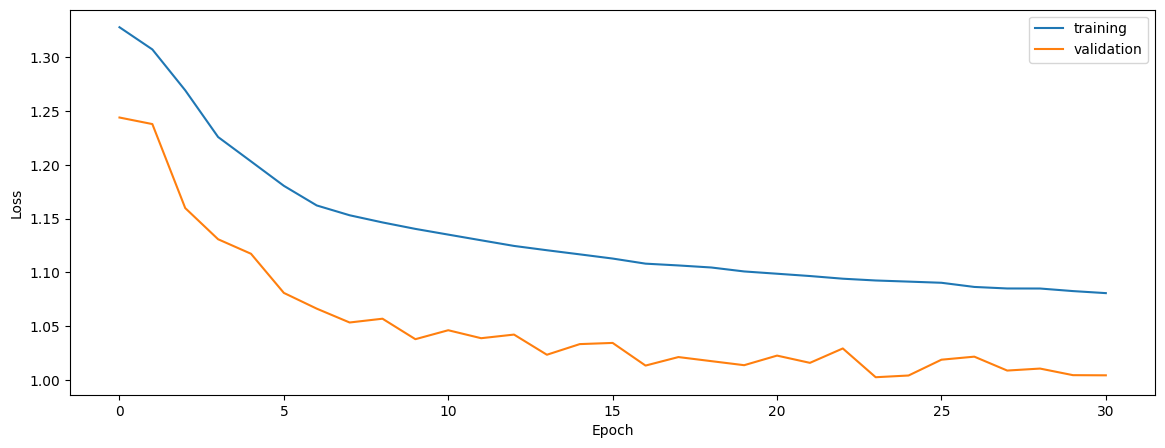

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.6267640124724314
0.6580652969018933
0.6606387155883251


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('native')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

native
0.6267640124724314
0.6580652969018933
0.6606387155883251


In [9]:
print('normalized')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

normalized
0.6257073460634092
0.6550775662889207
0.661550123176047


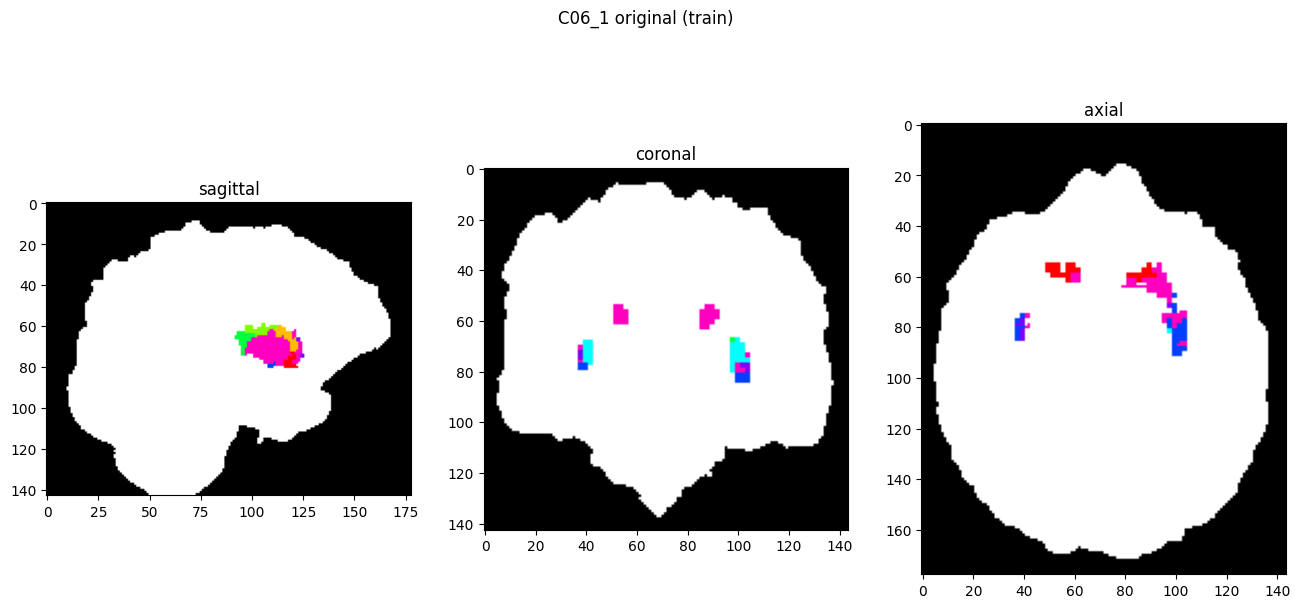

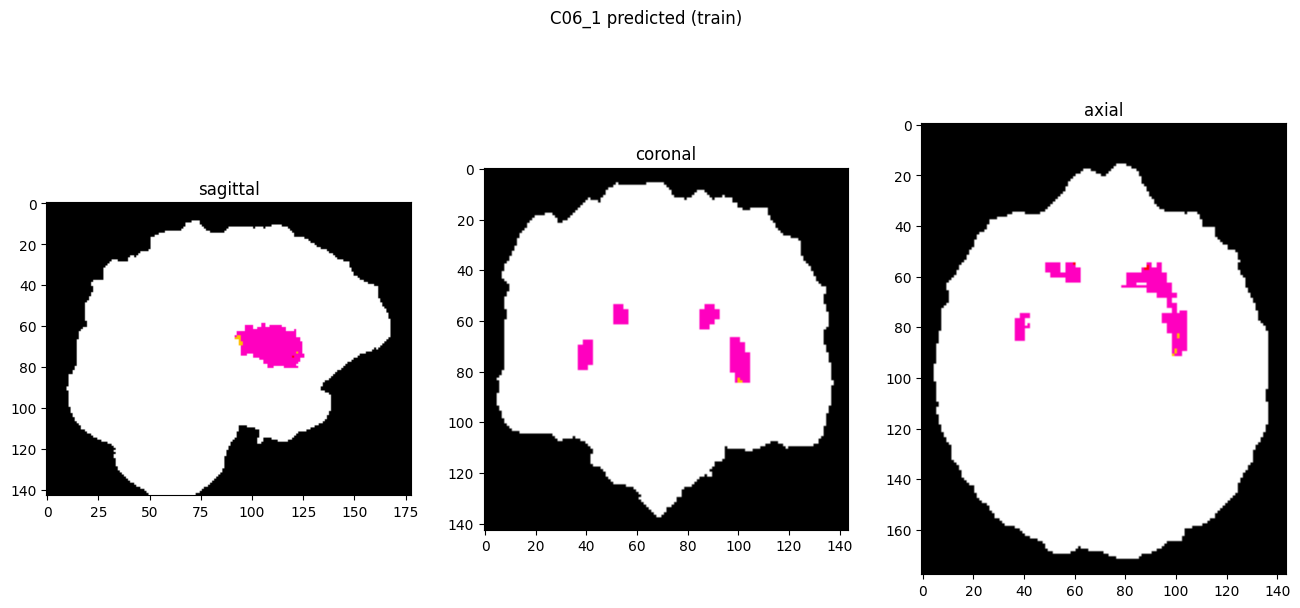

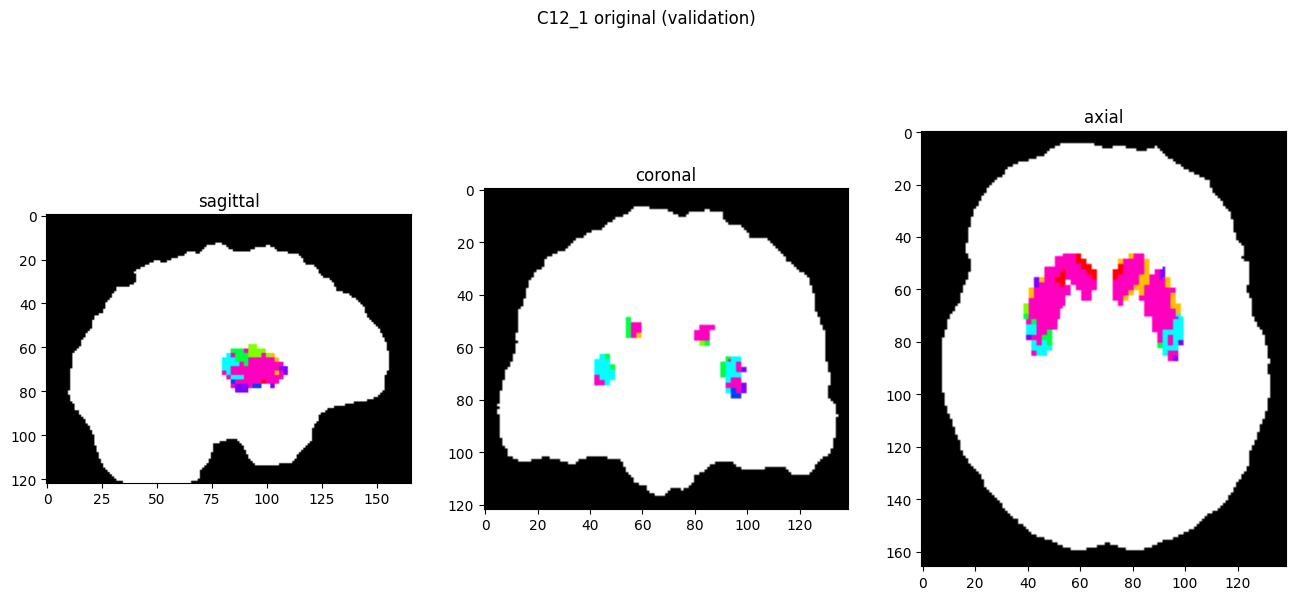

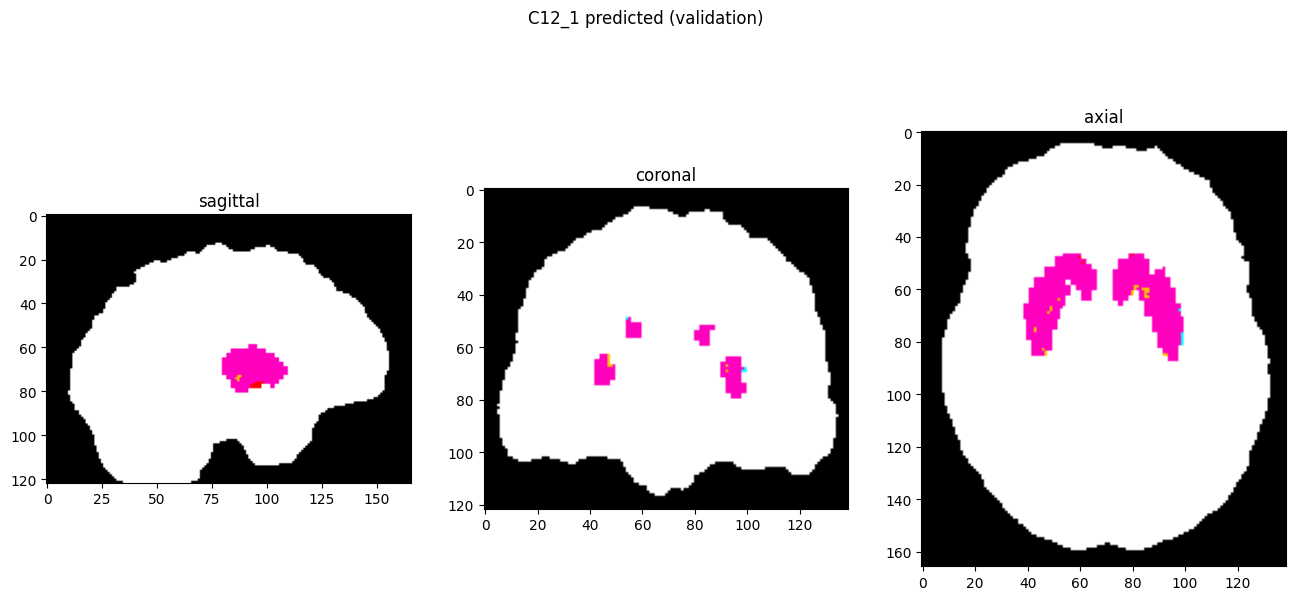

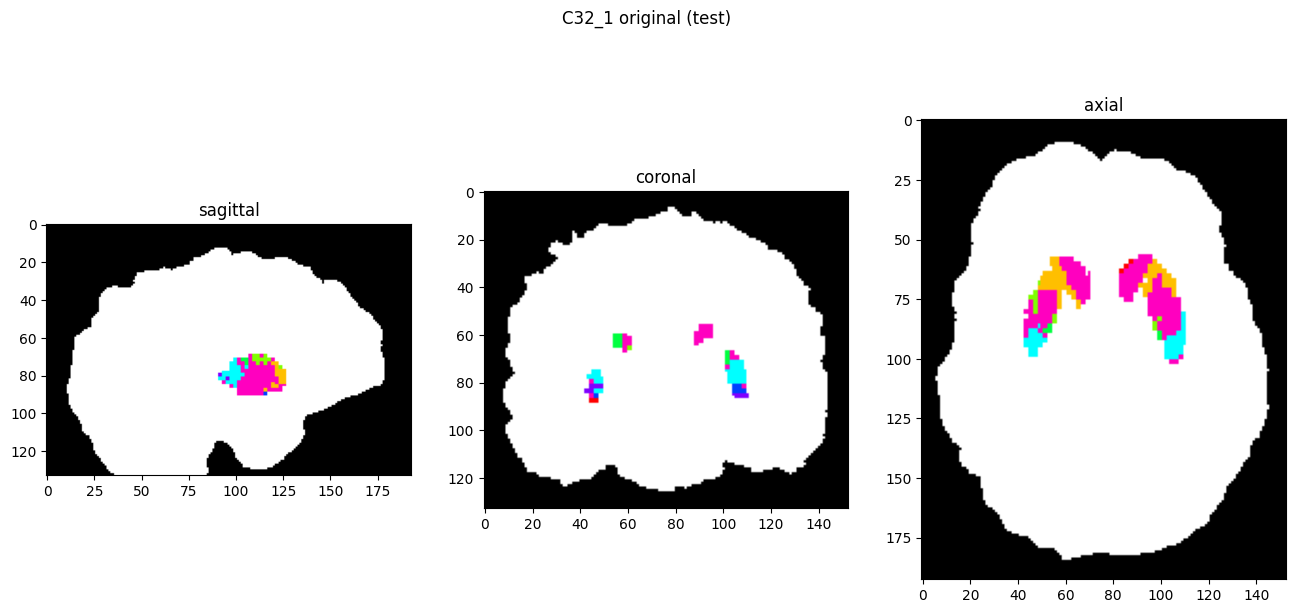

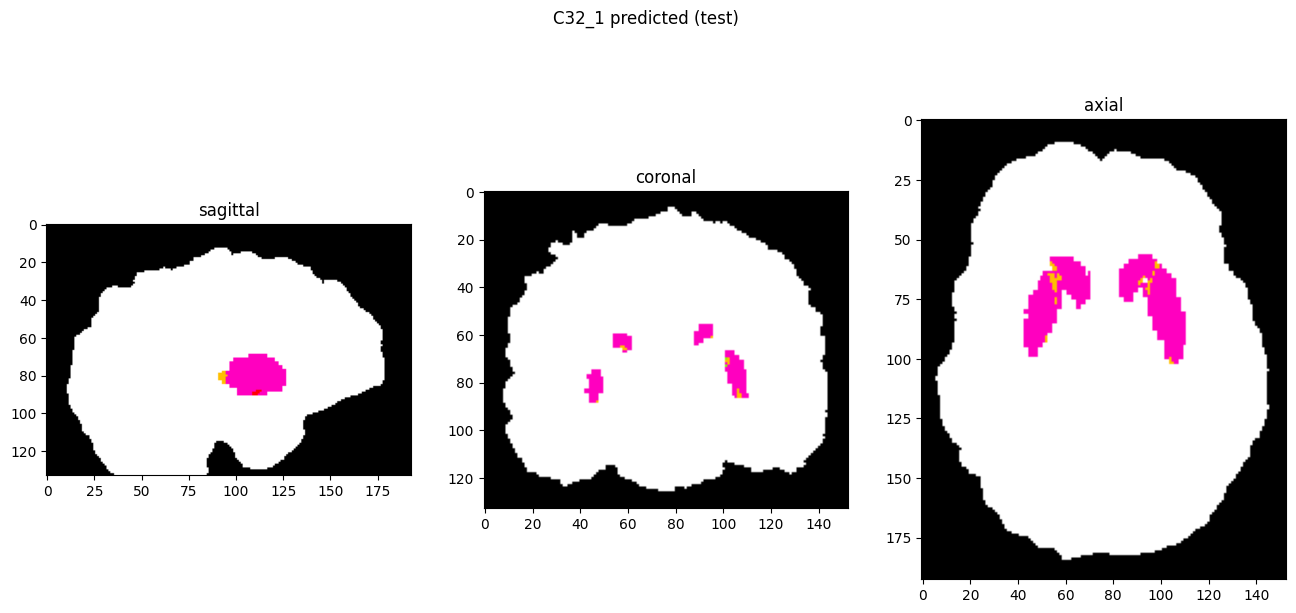

In [10]:
showResults(model, gen, threshold=0)